<a href="https://colab.research.google.com/github/AustinPariseau/IS4487-Spring-Real/blob/main/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 4487 Lab 10

## Outline

Repeat exercises from Lab 9, but with the *Air Quality Daily AQI* dataset.

Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

Your target variable is *CATEGORY*, indicating if the air is healthy.  You can focus on either the entire country, split the country in regions, or focus on just one area (ex. Utah).   You can reduce noise by aggregating the data to the month of season level.   

Can you predict the category based on the location and time of year?  

The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [13]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the air quality dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv ('/content/gdrive/MyDrive/IS 4487 Colab/daily_aqi_by_county_2023.csv')

df.describe()

Mounted at /content/gdrive


,State Code,County Code,AQI,Number of Sites Reporting
count,185017.000000,185017.000000,185017.000000,185017.000000
mean,29.936773,81.188415,43.498397,1.878595
std,15.904884,93.001539,23.905791,2.273400
min,1.000000,1.000000,0.000000,1.000000
25%,17.000000,23.000000,31.000000,1.000000
50%,30.000000,59.000000,41.000000,1.000000
75%,42.000000,107.000000,50.000000,2.000000
max,80.000000,810.000000,1695.000000,33.000000


## Prepare Data

➡️ Assignment Tasks
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI

In [3]:
#create columns
df_dummy = pd.get_dummies(df['Defining Parameter'], prefix='DefiningParam', drop_first=True)

df['Month'] = pd.to_datetime(df['Date']).dt.month

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(month_to_season)

null_check = df.isnull().sum()
description = df.describe()

df = pd.concat([df, df_dummy], axis=1)
null_check, description, df.head()


(State Name                   0
 county Name                  0
 State Code                   0
 County Code                  0
 Date                         0
 AQI                          0
 Category                     0
 Defining Parameter           0
 Defining Site                0
 Number of Sites Reporting    0
 Month                        0
 Season                       0
 dtype: int64,
           State Code    County Code            AQI  Number of Sites Reporting  \
 count  185017.000000  185017.000000  185017.000000              185017.000000   
 mean       29.936773      81.188415      43.498397                   1.878595   
 std        15.904884      93.001539      23.905791                   2.273400   
 min         1.000000       1.000000       0.000000                   1.000000   
 25%        17.000000      23.000000      31.000000                   1.000000   
 50%        30.000000      59.000000      41.000000                   1.000000   
 75%        42.000000     1

In [10]:
#select final columns for use

df = pd.concat([df, df_dummy], axis=1)
null_check, description, df.head()

(State Name                   0
 county Name                  0
 State Code                   0
 County Code                  0
 Date                         0
 AQI                          0
 Category                     0
 Defining Parameter           0
 Defining Site                0
 Number of Sites Reporting    0
 Month                        0
 Season                       0
 dtype: int64,
           State Code    County Code            AQI  Number of Sites Reporting  \
 count  185017.000000  185017.000000  185017.000000              185017.000000   
 mean       29.936773      81.188415      43.498397                   1.878595   
 std        15.904884      93.001539      23.905791                   2.273400   
 min         1.000000       1.000000       0.000000                   1.000000   
 25%        17.000000      23.000000      31.000000                   1.000000   
 50%        30.000000      59.000000      41.000000                   1.000000   
 75%        42.000000     1

In [11]:
df_monthly_mean = df.groupby(['State Code', 'County Code', 'Month']).agg(
    AQI_mean=('AQI', 'mean')).reset_index()

df_merged = pd.merge(df_monthly_mean, df[['State Code', 'County Code', 'Month', 'Season', 'Category'] + list(df_dummy.columns)],
                     on=['State Code', 'County Code', 'Month'], how='left')

df_final = df_merged.drop_duplicates(subset=['State Code', 'County Code', 'Month'])

df_final.head()

,State Code,County Code,Month,AQI_mean,Season,Category,DefiningParam_NO2,DefiningParam_NO2,DefiningParam_NO2,DefiningParam_NO2,...,DefiningParam_Ozone,DefiningParam_Ozone,DefiningParam_PM10,DefiningParam_PM10,DefiningParam_PM10,DefiningParam_PM10,DefiningParam_PM2.5,DefiningParam_PM2.5,DefiningParam_PM2.5,DefiningParam_PM2.5
0,1,3,1,22.454545,Winter,Good,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
22,1,3,2,28.785714,Winter,Good,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
50,1,3,3,41.172414,Spring,Good,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
79,1,3,4,41.133333,Spring,Good,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
109,1,3,5,44.741935,Spring,Moderate,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


## Create Regression

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.
- Visualize the regression with at least one of the variables

In [14]:
#create regression
season_encoding = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
df_final['Season_encoded'] = df_final['Season'].map(season_encoding)

X = df_final[['State Code', 'County Code', 'Month', 'Season_encoded'] + list(df_dummy.columns.drop_duplicates())]
y = df_final['AQI_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

X_test_with_pred = X_test.copy()
X_test_with_pred['AQI_predicted'] = y_pred
monthly_pred = X_test_with_pred.groupby('Month')['AQI_predicted'].mean().reset_index()

mse, r2, monthly_pred

<ipython-input-14-b8e5f7bb3569>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Season_encoded'] = df_final['Season'].map(season_encoding)


(157.7187616228854,
 0.3640803501656944,
    Month  AQI_predicted
 0      1      35.551348
 1      2      35.520619
 2      3      42.408315
 3      4      44.199295
 4      5      44.225047
 5      6      49.336678
 6      7      42.202134
 7      8      45.385572
 8      9      41.904114
 9     10      10.027376)

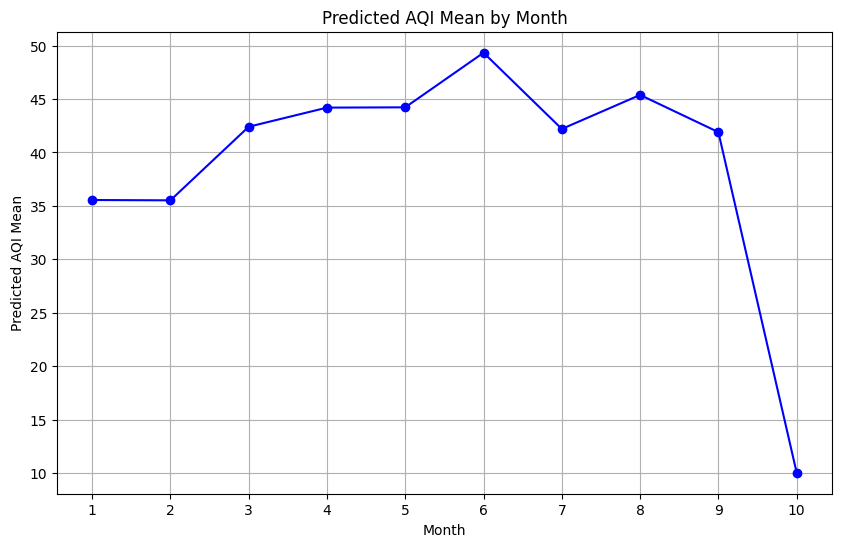

In [15]:
#visual
plt.figure(figsize=(10, 6))
plt.plot(monthly_pred['Month'], monthly_pred['AQI_predicted'], marker='o', linestyle='-', color='b')
plt.title('Predicted AQI Mean by Month')
plt.xlabel('Month')
plt.ylabel('Predicted AQI Mean')
plt.grid(True)
plt.xticks(monthly_pred['Month'])
plt.show()

## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in the month of January?  

I would have to predict that it would be in the good category. I think the main factor that goes into this location. To get an exact prediction you would have to create a model that can take in all factors given but we would also need where we would want to predict.

## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from a year 20 years prior, using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [7]:
#import, append and create new model